In [157]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysal as ps
import shapely
import libpysal

In [158]:
import scienceplots
plt.style.use(['science', 'ieee'])

# Data Load

In [159]:
libpysal.examples.available()

Name                                        Description  Installed
0       10740  Albuquerque, New Mexico, Census 2000 Tract Dat...       True
1      AirBnB  Airbnb rentals, socioeconomics, and crime in C...      False
2     Atlanta       Atlanta, GA region homicide counts and rates      False
3   Baltimore          Baltimore house sales prices and hedonics      False
4   Bostonhsg               Boston housing and neighborhood data      False
..        ...                                                ...        ...
93        taz           Traffic Analysis Zones in So. California      False
94      tokyo                               Tokyo Mortality data       True
95  us_income  Per-capita income for the lower 48 US states 1...       True
96   virginia                        Virginia counties shapefile       True
97       wmat          Datasets used for spatial weights testing       True

[98 rows x 3 columns]

In [160]:
# example data : San Francisco crime data

libpysal.examples.explain('SanFran Crime')

In [161]:
# Download the data
libpysal.examples.load_example('SanFran Crime')

In [162]:
# Load
from libpysal.examples import load_example

data = load_example('SanFran Crime')

data.get_file_list()

['/Users/dangchan/Library/Application Support/pysal/SanFran_Crime/__MACOSX/SFCrime_July_Dec2012 2/._.DS_Store',
 '/Users/dangchan/Library/Application Support/pysal/SanFran_Crime/__MACOSX/SFCrime_July_Dec2012 2/SF PD Plots/._.DS_Store',
 '/Users/dangchan/Library/Application Support/pysal/SanFran_Crime/__MACOSX/SFCrime_July_Dec2012 2/SF PD Plots/._SFCrime_blocks.prj',
 '/Users/dangchan/Library/Application Support/pysal/SanFran_Crime/__MACOSX/SFCrime_July_Dec2012 2/SF PD Plots/._SFCrime_blocks.shx',
 '/Users/dangchan/Library/Application Support/pysal/SanFran_Crime/__MACOSX/SFCrime_July_Dec2012 2/SF PD Plots/._SFCrime_blocks.shp',
 '/Users/dangchan/Library/Application Support/pysal/SanFran_Crime/__MACOSX/SFCrime_July_Dec2012 2/SF PD Plots/._SFCrime_blocks.dbf',
 '/Users/dangchan/Library/Application Support/pysal/SanFran_Crime/__MACOSX/SFCrime_July_Dec2012 2/Crime Events/._sf_drugs.dbf',
 '/Users/dangchan/Library/Application Support/pysal/SanFran_Crime/__MACOSX/SFCrime_July_Dec2012 2/Crime 

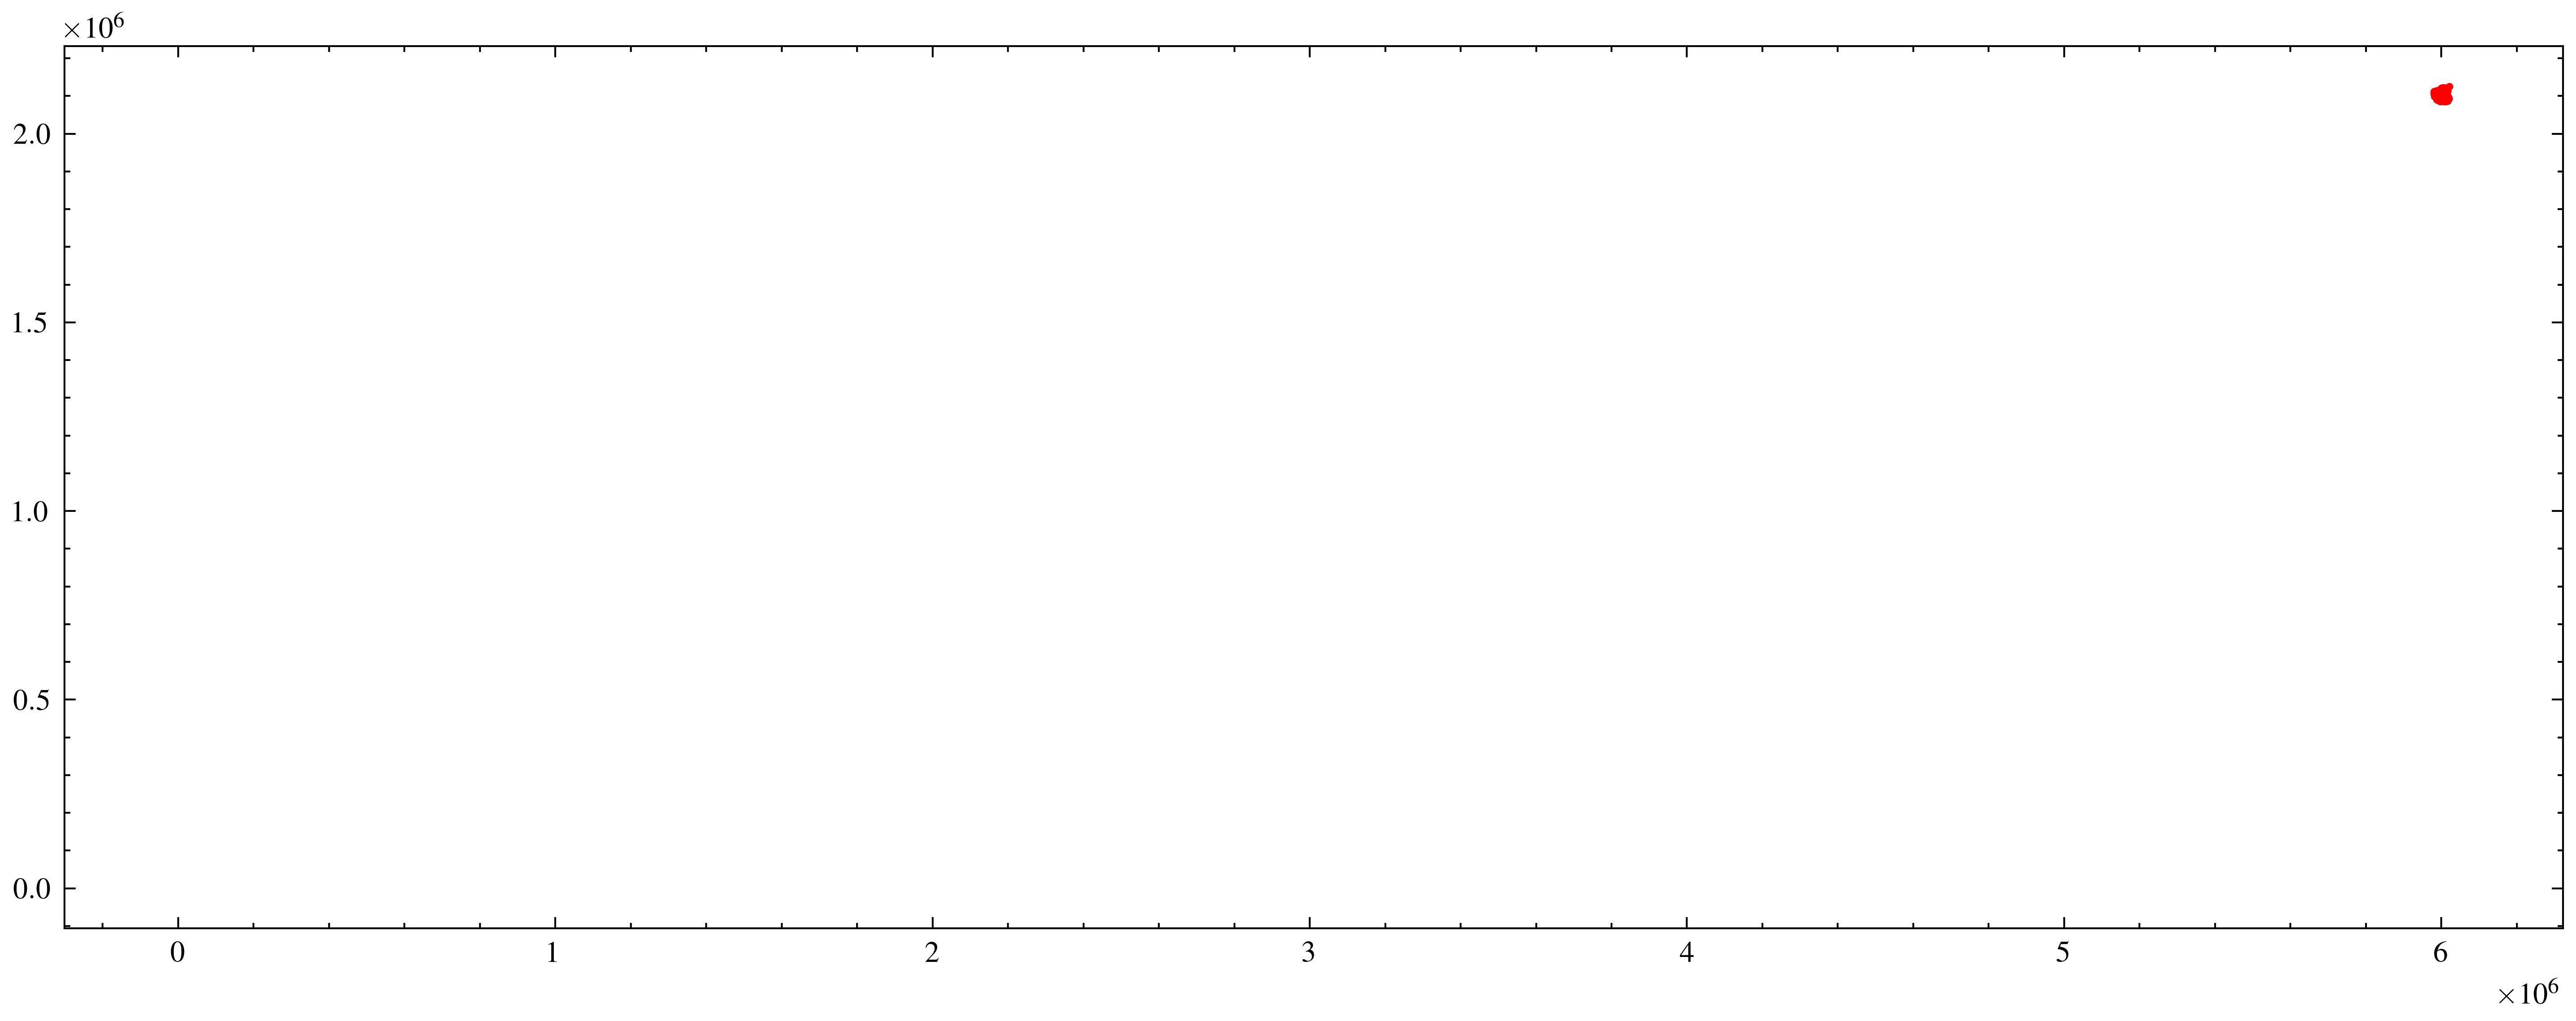

In [163]:
# Load the shapefile
drugs = gpd.read_file(data.get_path('sf_drugs.shp'))
blocks = gpd.read_file(data.get_path('SFCrime_blocks.shp'))

# Plot

fig, ax = plt.subplots(figsize=(12,10))
blocks.boundary.plot(ax=ax)
drugs.plot(ax=ax, color='red', markersize=1)
plt.show()

EPSG:4269
EPSG:2227


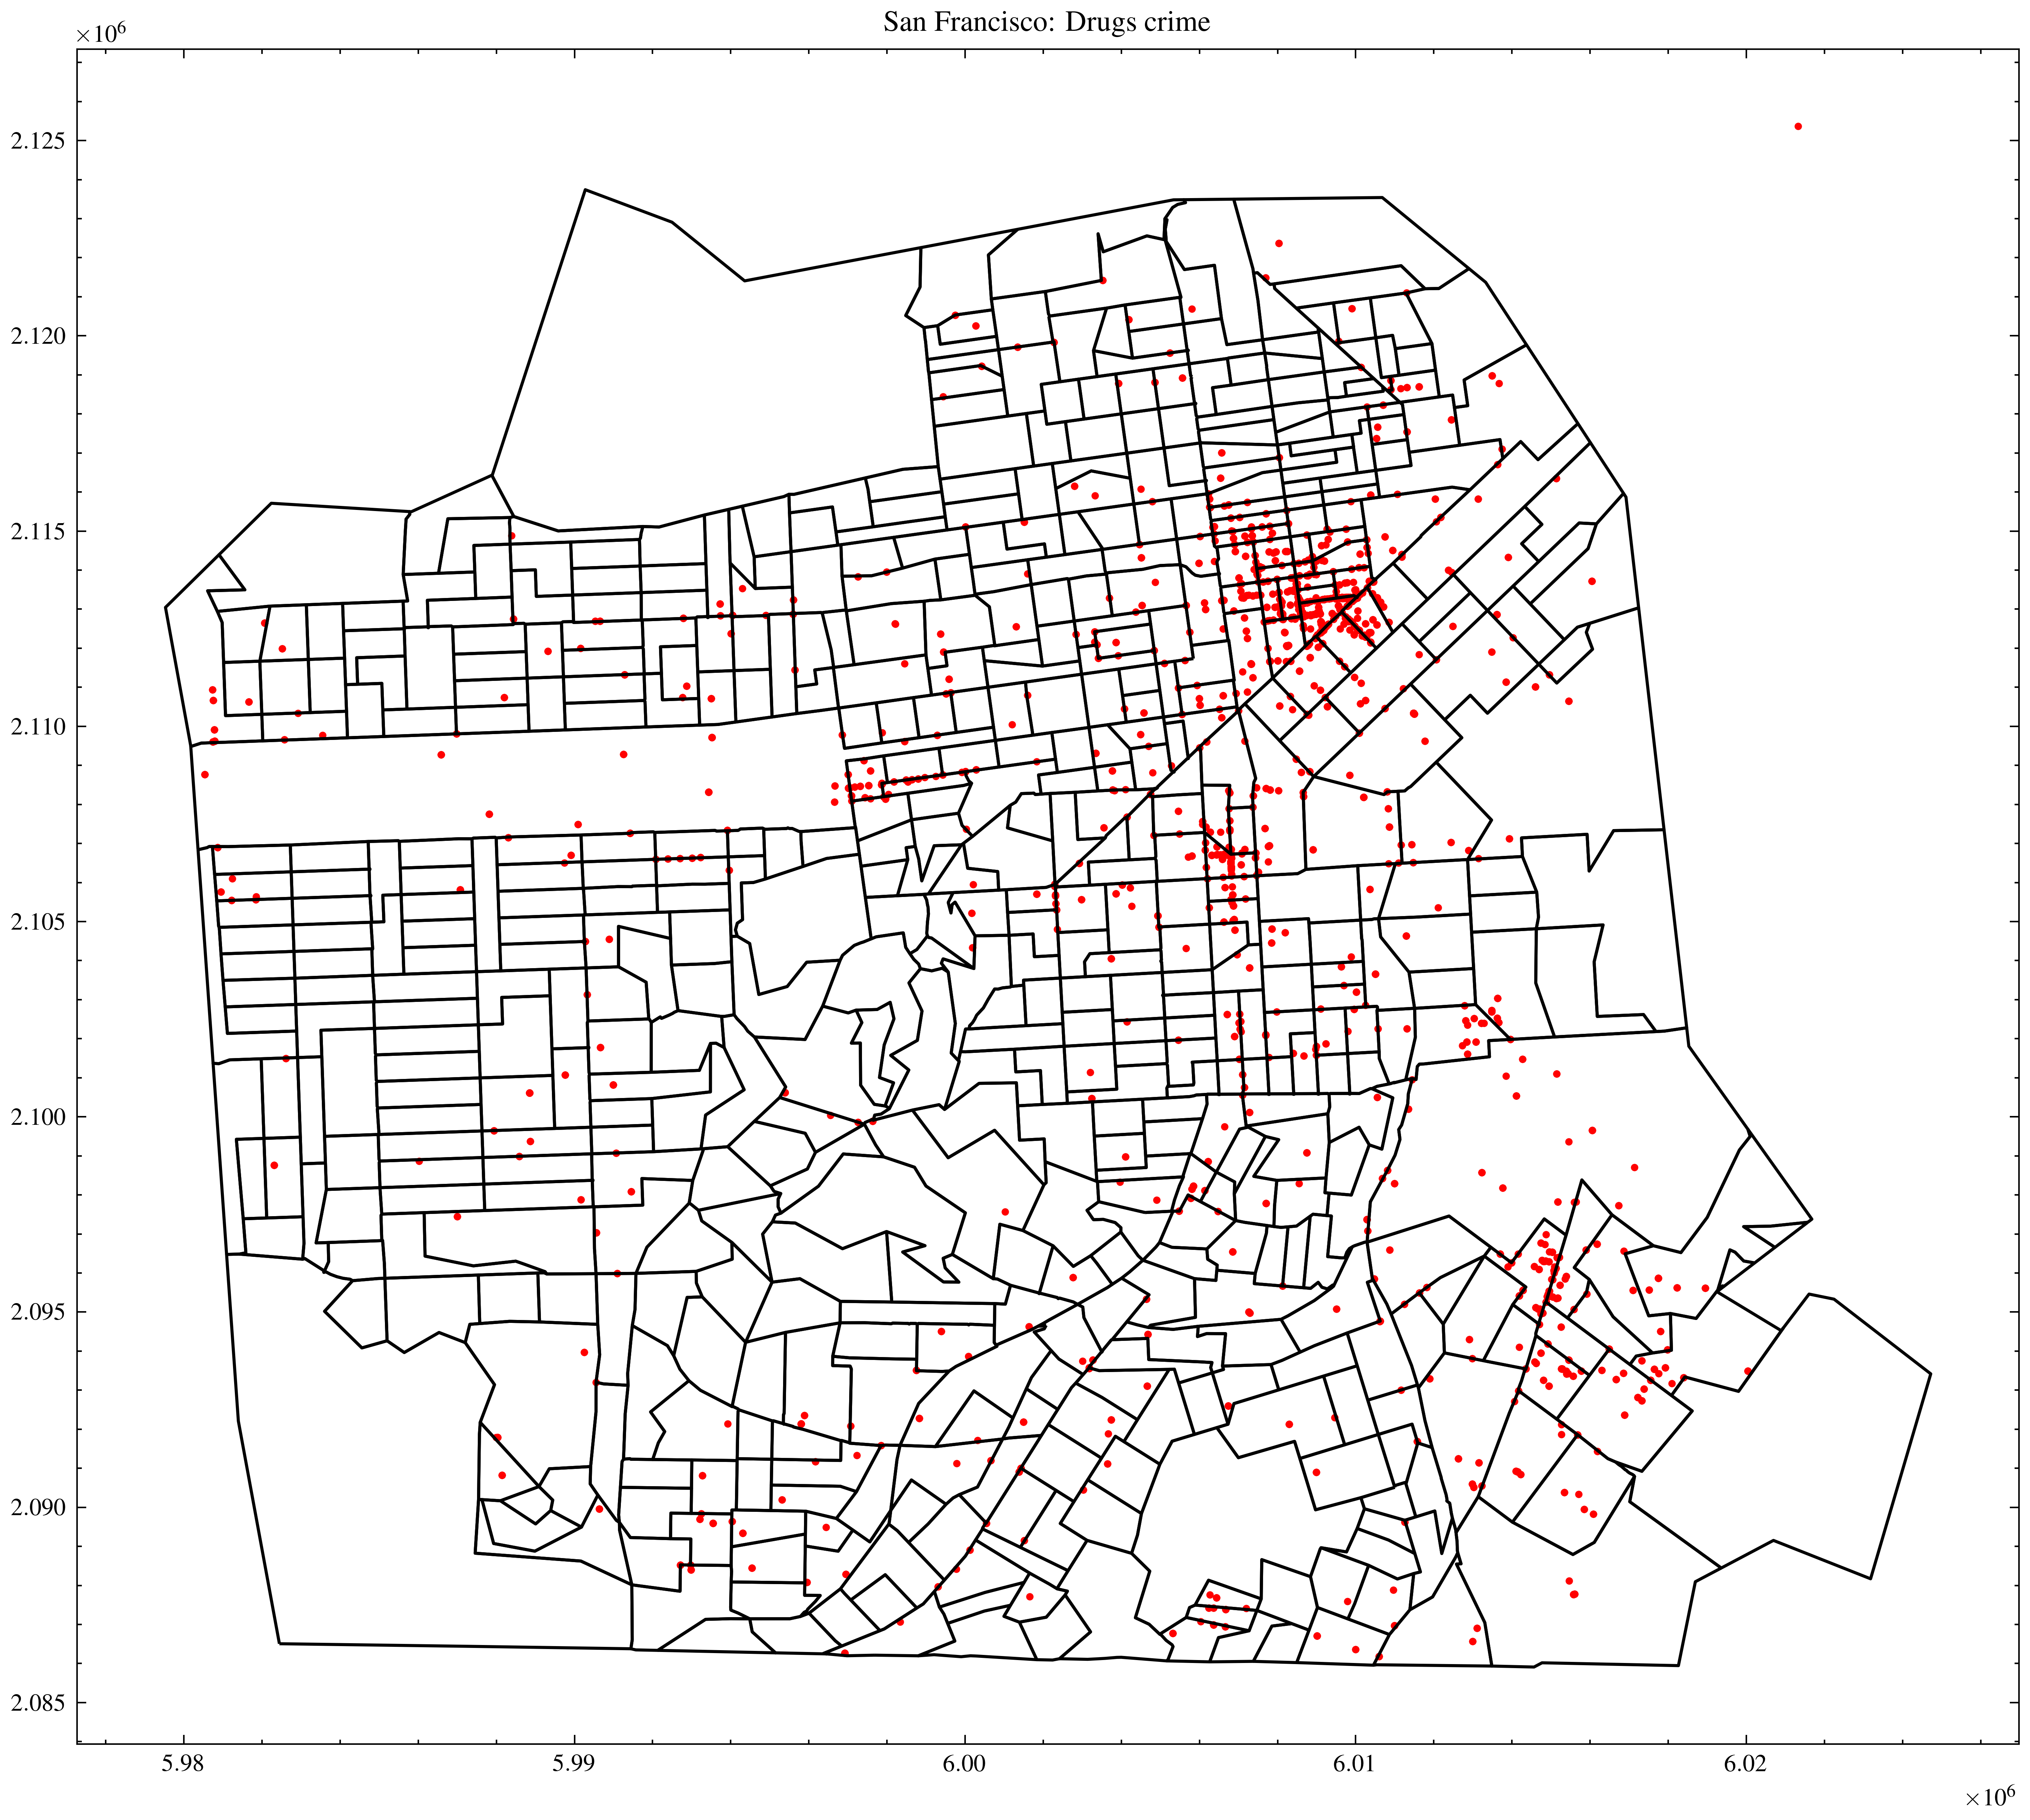

In [164]:
# Check coordinates

print(blocks.crs)
print(drugs.crs) # different

# Reproject

blocks = blocks.to_crs(drugs.crs)

# Plot

fig, ax = plt.subplots(figsize=(12,10))
blocks.boundary.plot(ax=ax, lw=1)
drugs.plot(ax=ax, color='red', markersize=2)
ax.set_title('San Francisco: Drugs crime')
plt.show()

# Point pattern

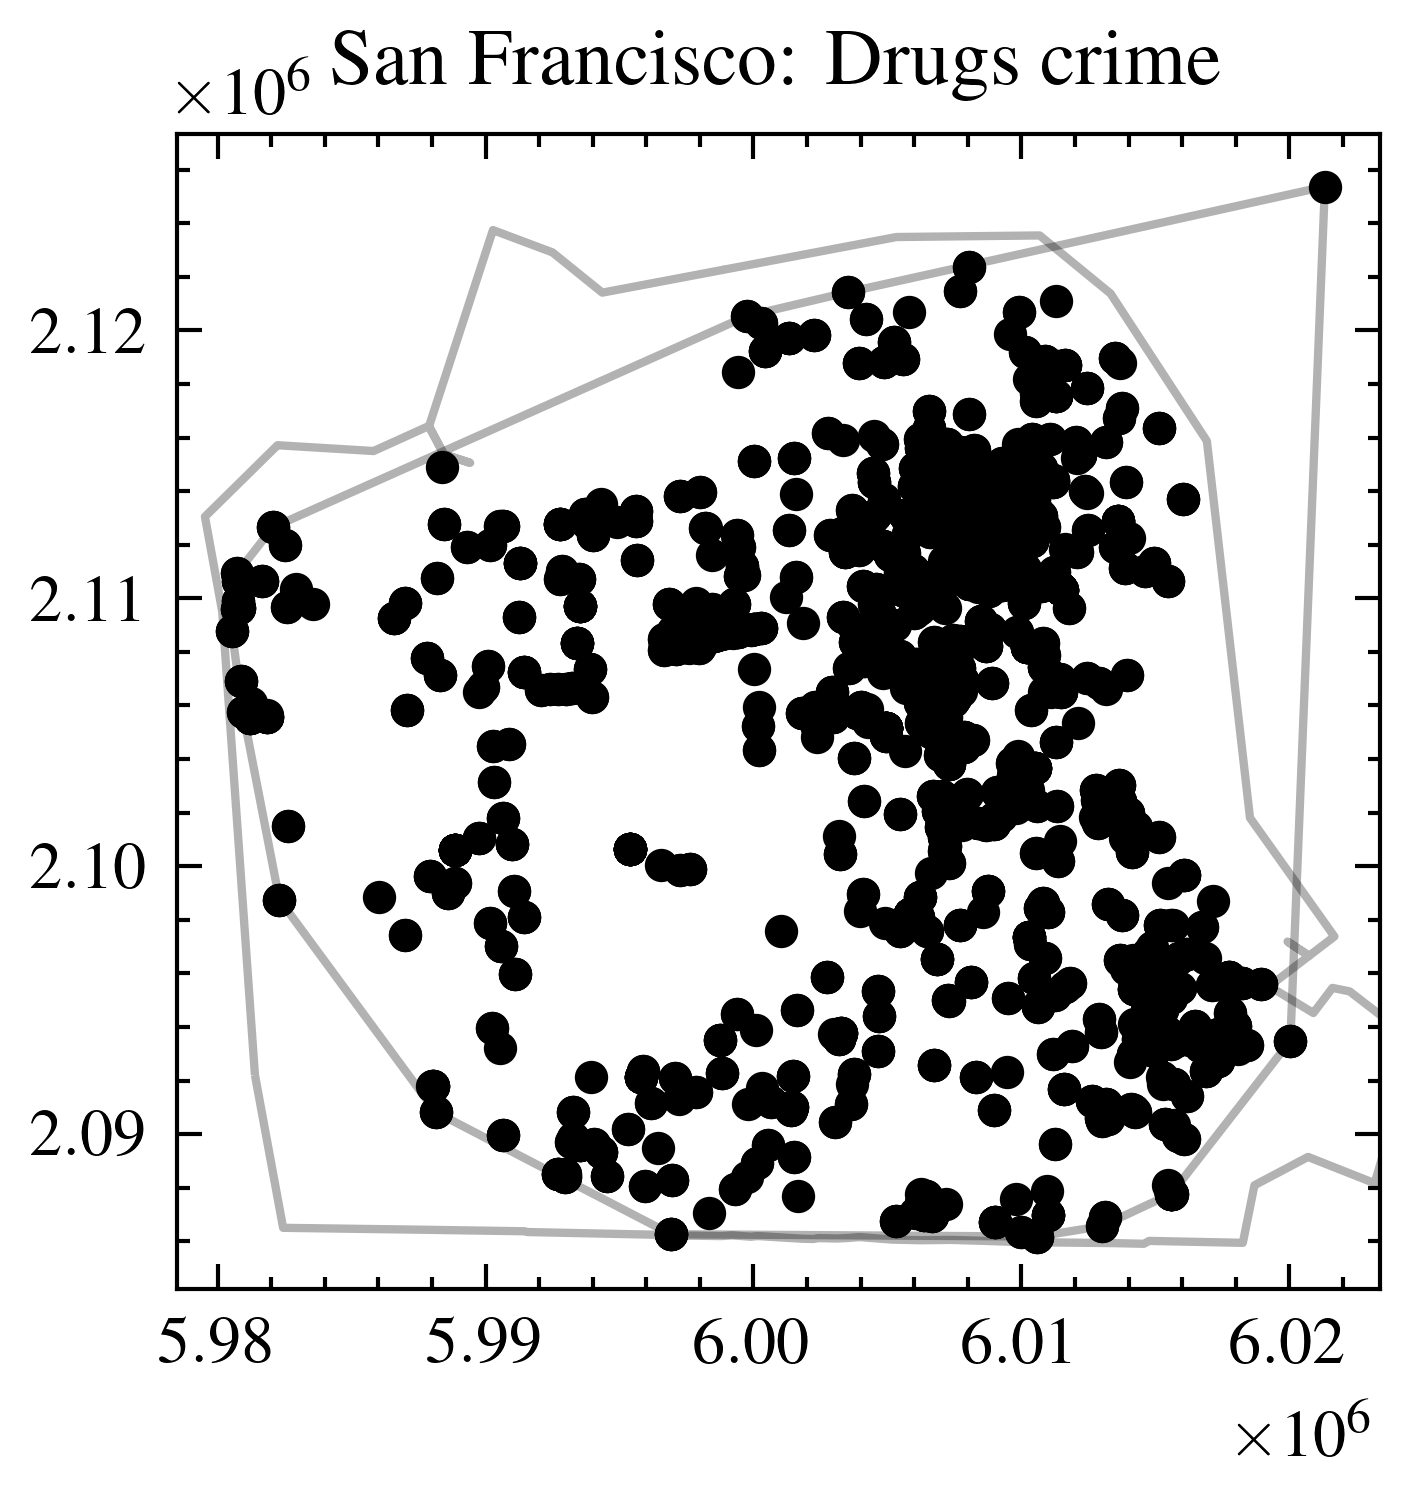

In [165]:
from pointpats import PointPattern, PointProcess, PoissonPointProcess, as_window

# to numpy array
poly = libpysal.cg.Polygon(list(blocks.unary_union.exterior.coords))
points = np.array([libpysal.cg.Point(p) for p in drugs.geometry.apply(lambda p: (p.x, p.y))])

# Create a point pattern and window
window = as_window(poly)
pp = PointPattern(points, window)

# Plot
pp.plot(window=True, hull=True, title='San Francisco: Drugs crime')
plt.show()

In [166]:
pp.window.area

1328485407.66687

# Intensity

In [167]:
intensity = pp.n / pp.window.area
print(intensity)

2.9334157360780046e-06


In [168]:
pp.lambda_window

2.9334157360780046e-06

In [169]:
print(pp.lambda_mbb) # 2.4379572813841635e-06
print(pp.lambda_hull) # 3.2061868363282854e-06

2.4379572813841635e-06
3.2061868363282854e-06


# CSR Point pattern

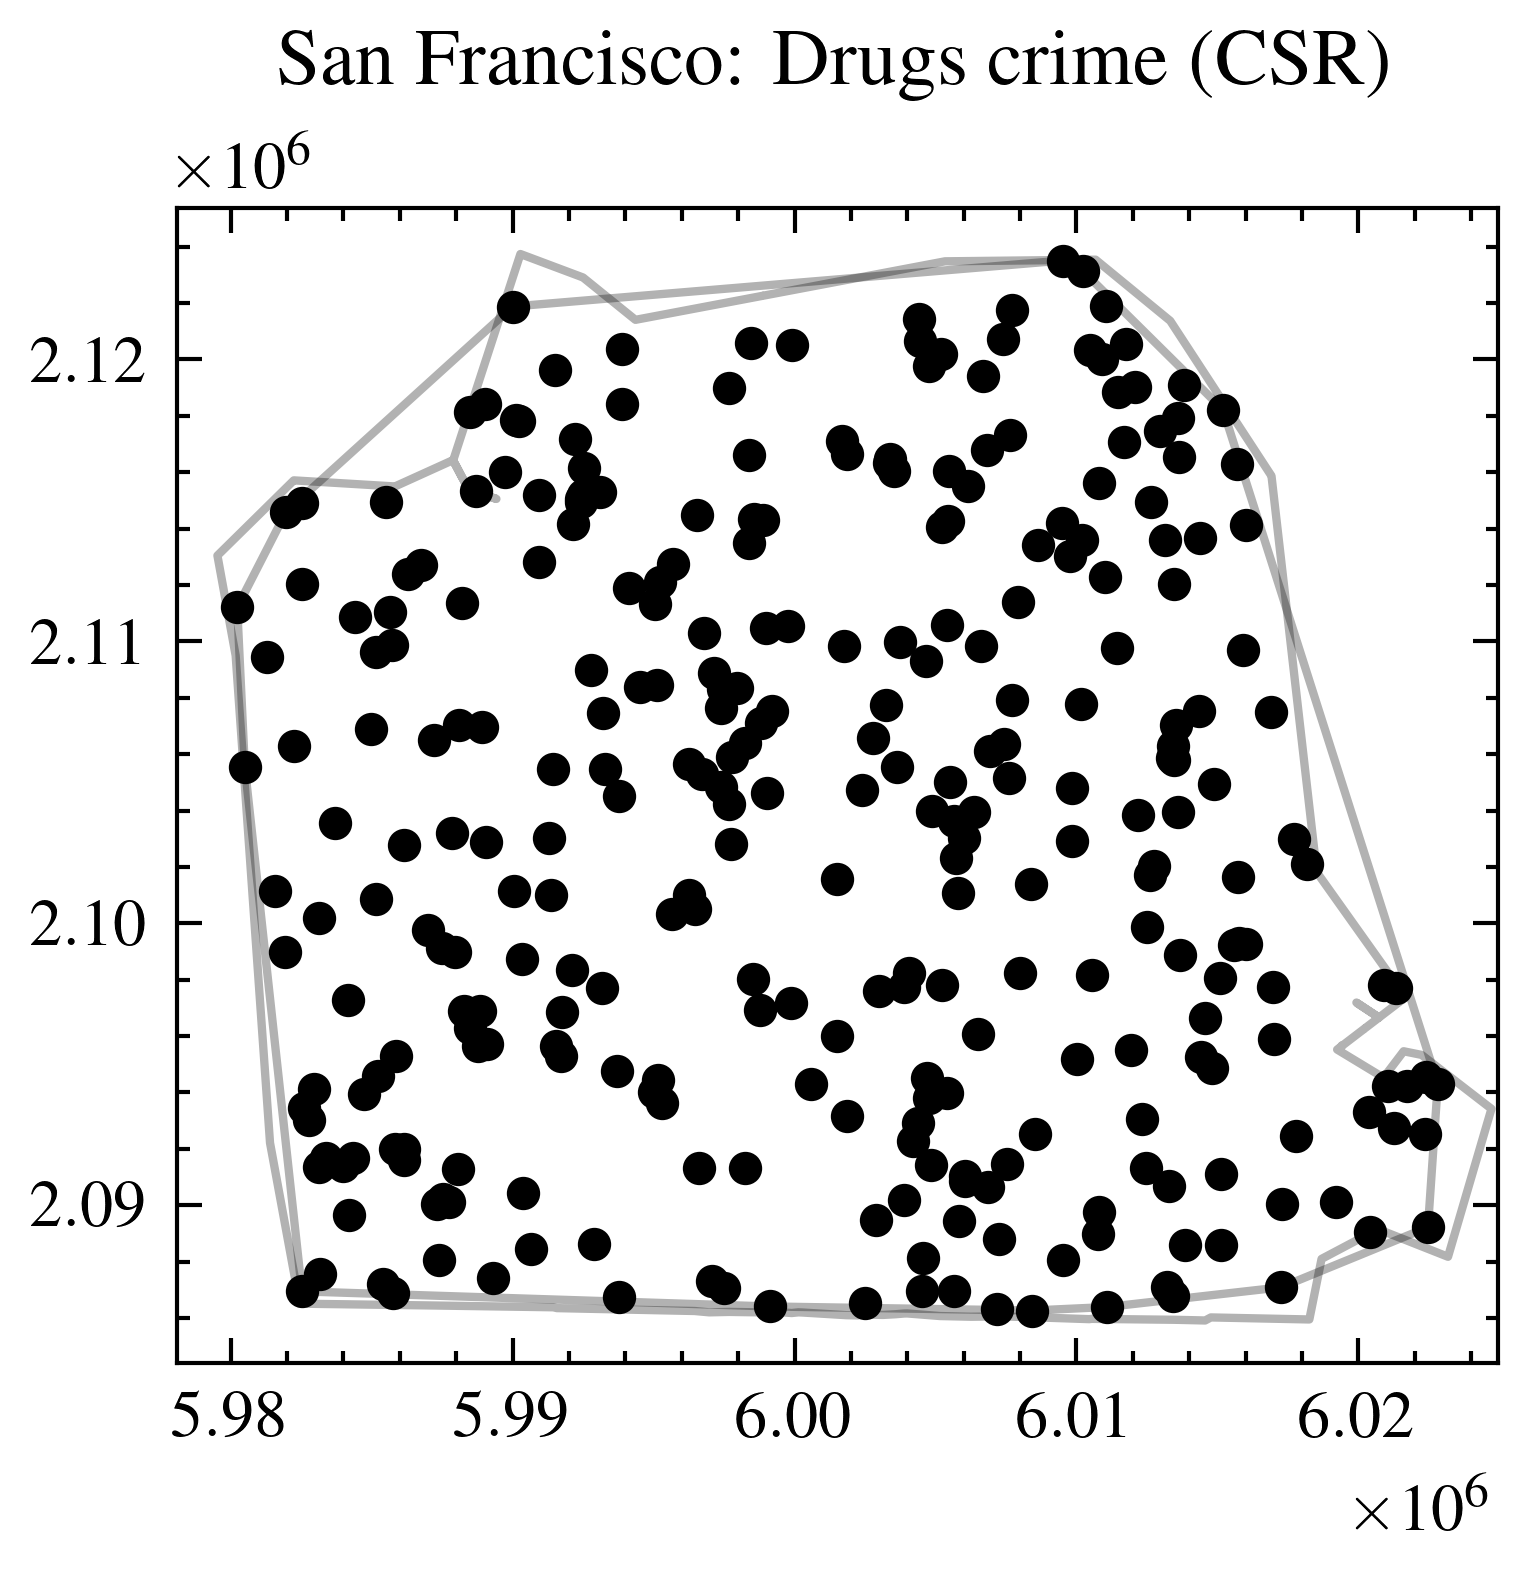

In [170]:
np.random.seed(1)

poisson = PoissonPointProcess(window=pp.window, samples=1, n=300, asPP=True)
pp_csr = poisson.realizations[0]

pp_csr.plot(window=True, hull=True, title='San Francisco: Drugs crime (CSR)')

# Quadrat Analysis

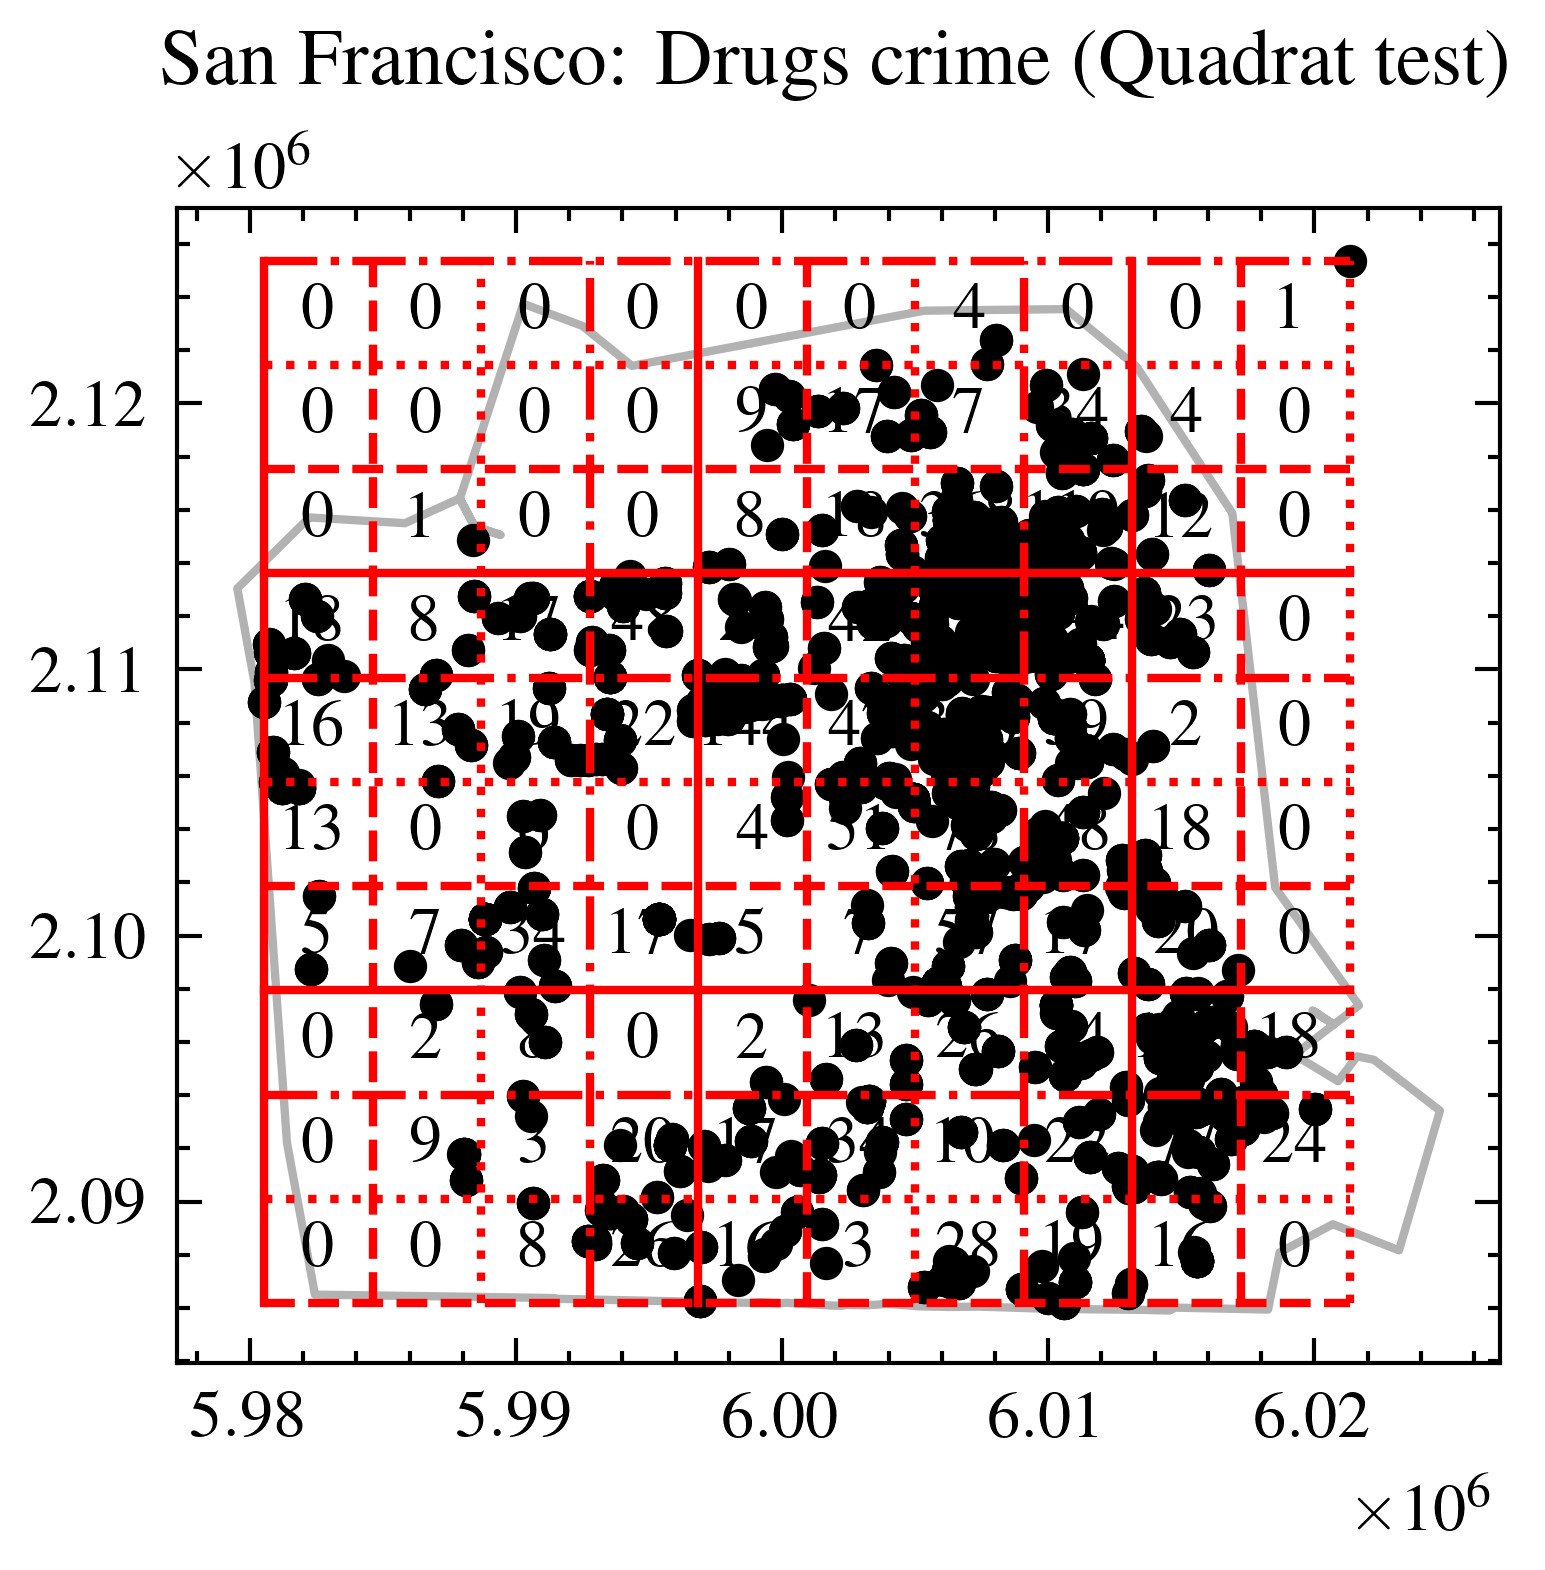

In [171]:
import pointpats.quadrat_statistics as qs

# Quadrat test
q = qs.QStatistic(pp, shape='rectangle', nx=10, ny=10)
ax = q.plot()
plt.title('San Francisco: Drugs crime (Quadrat test)')
plt.show()

In [172]:
# Chi-squared test
print(q.chi2)
print(q.chi2_pvalue)

36081.88119065948
0.0


# Kernel Density Estimation

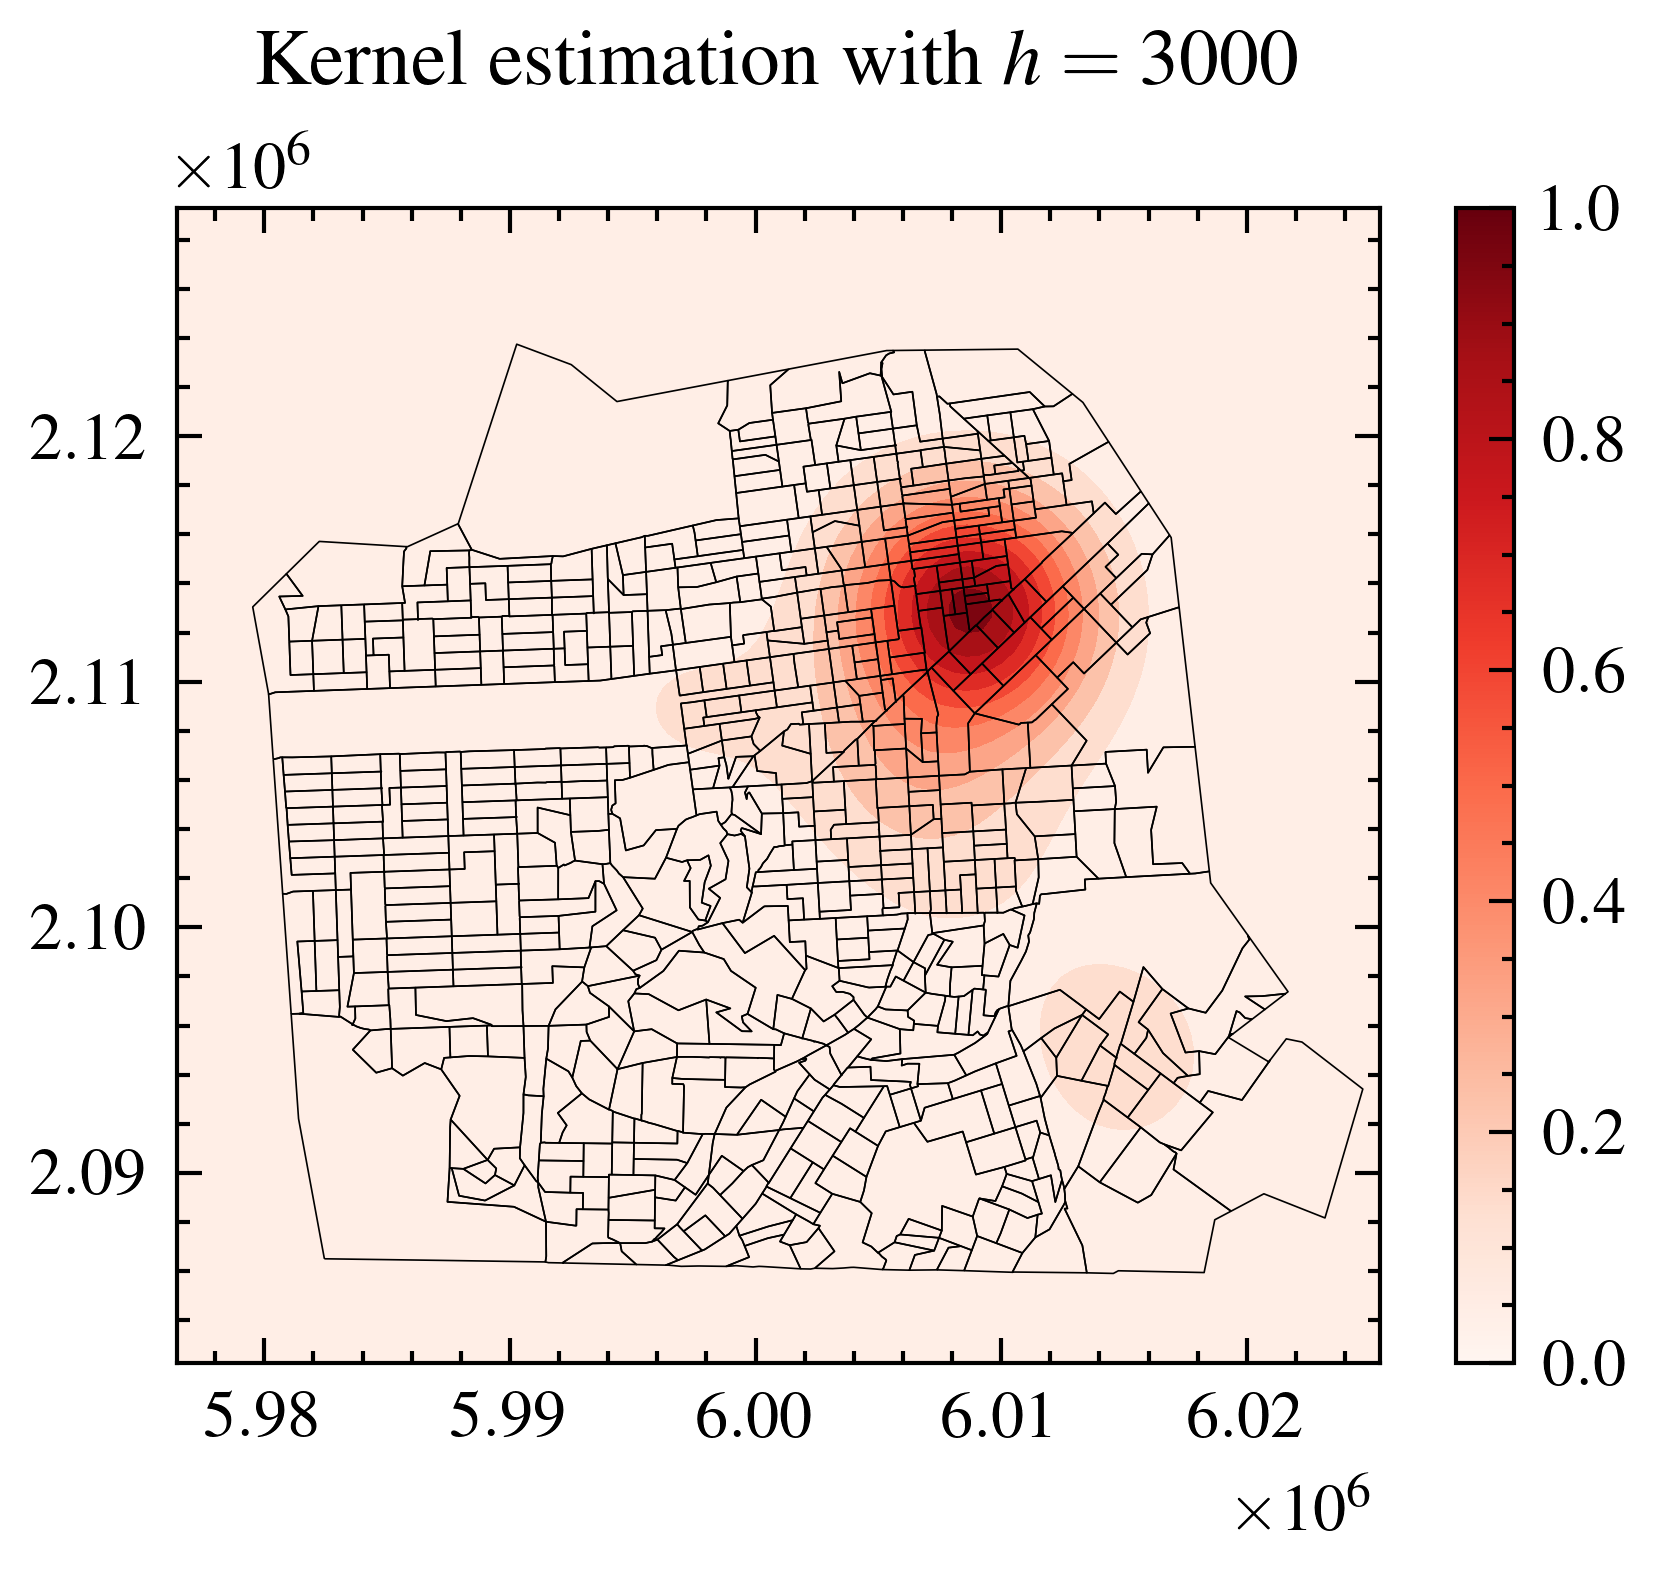

In [182]:
fig, ax = plt.subplots()
cs = plot_density(ax=ax, data=drugs, bandwidth=3000, cmap='Reds', fill=True)
cbar = fig.colorbar(mappable=None, orientation='vertical', cax=None, ax=ax, cmap='Reds')
blocks.boundary.plot(ax=ax, lw=0.2)
plt.title('Kernel estimation with $h=3000$')
plt.show()

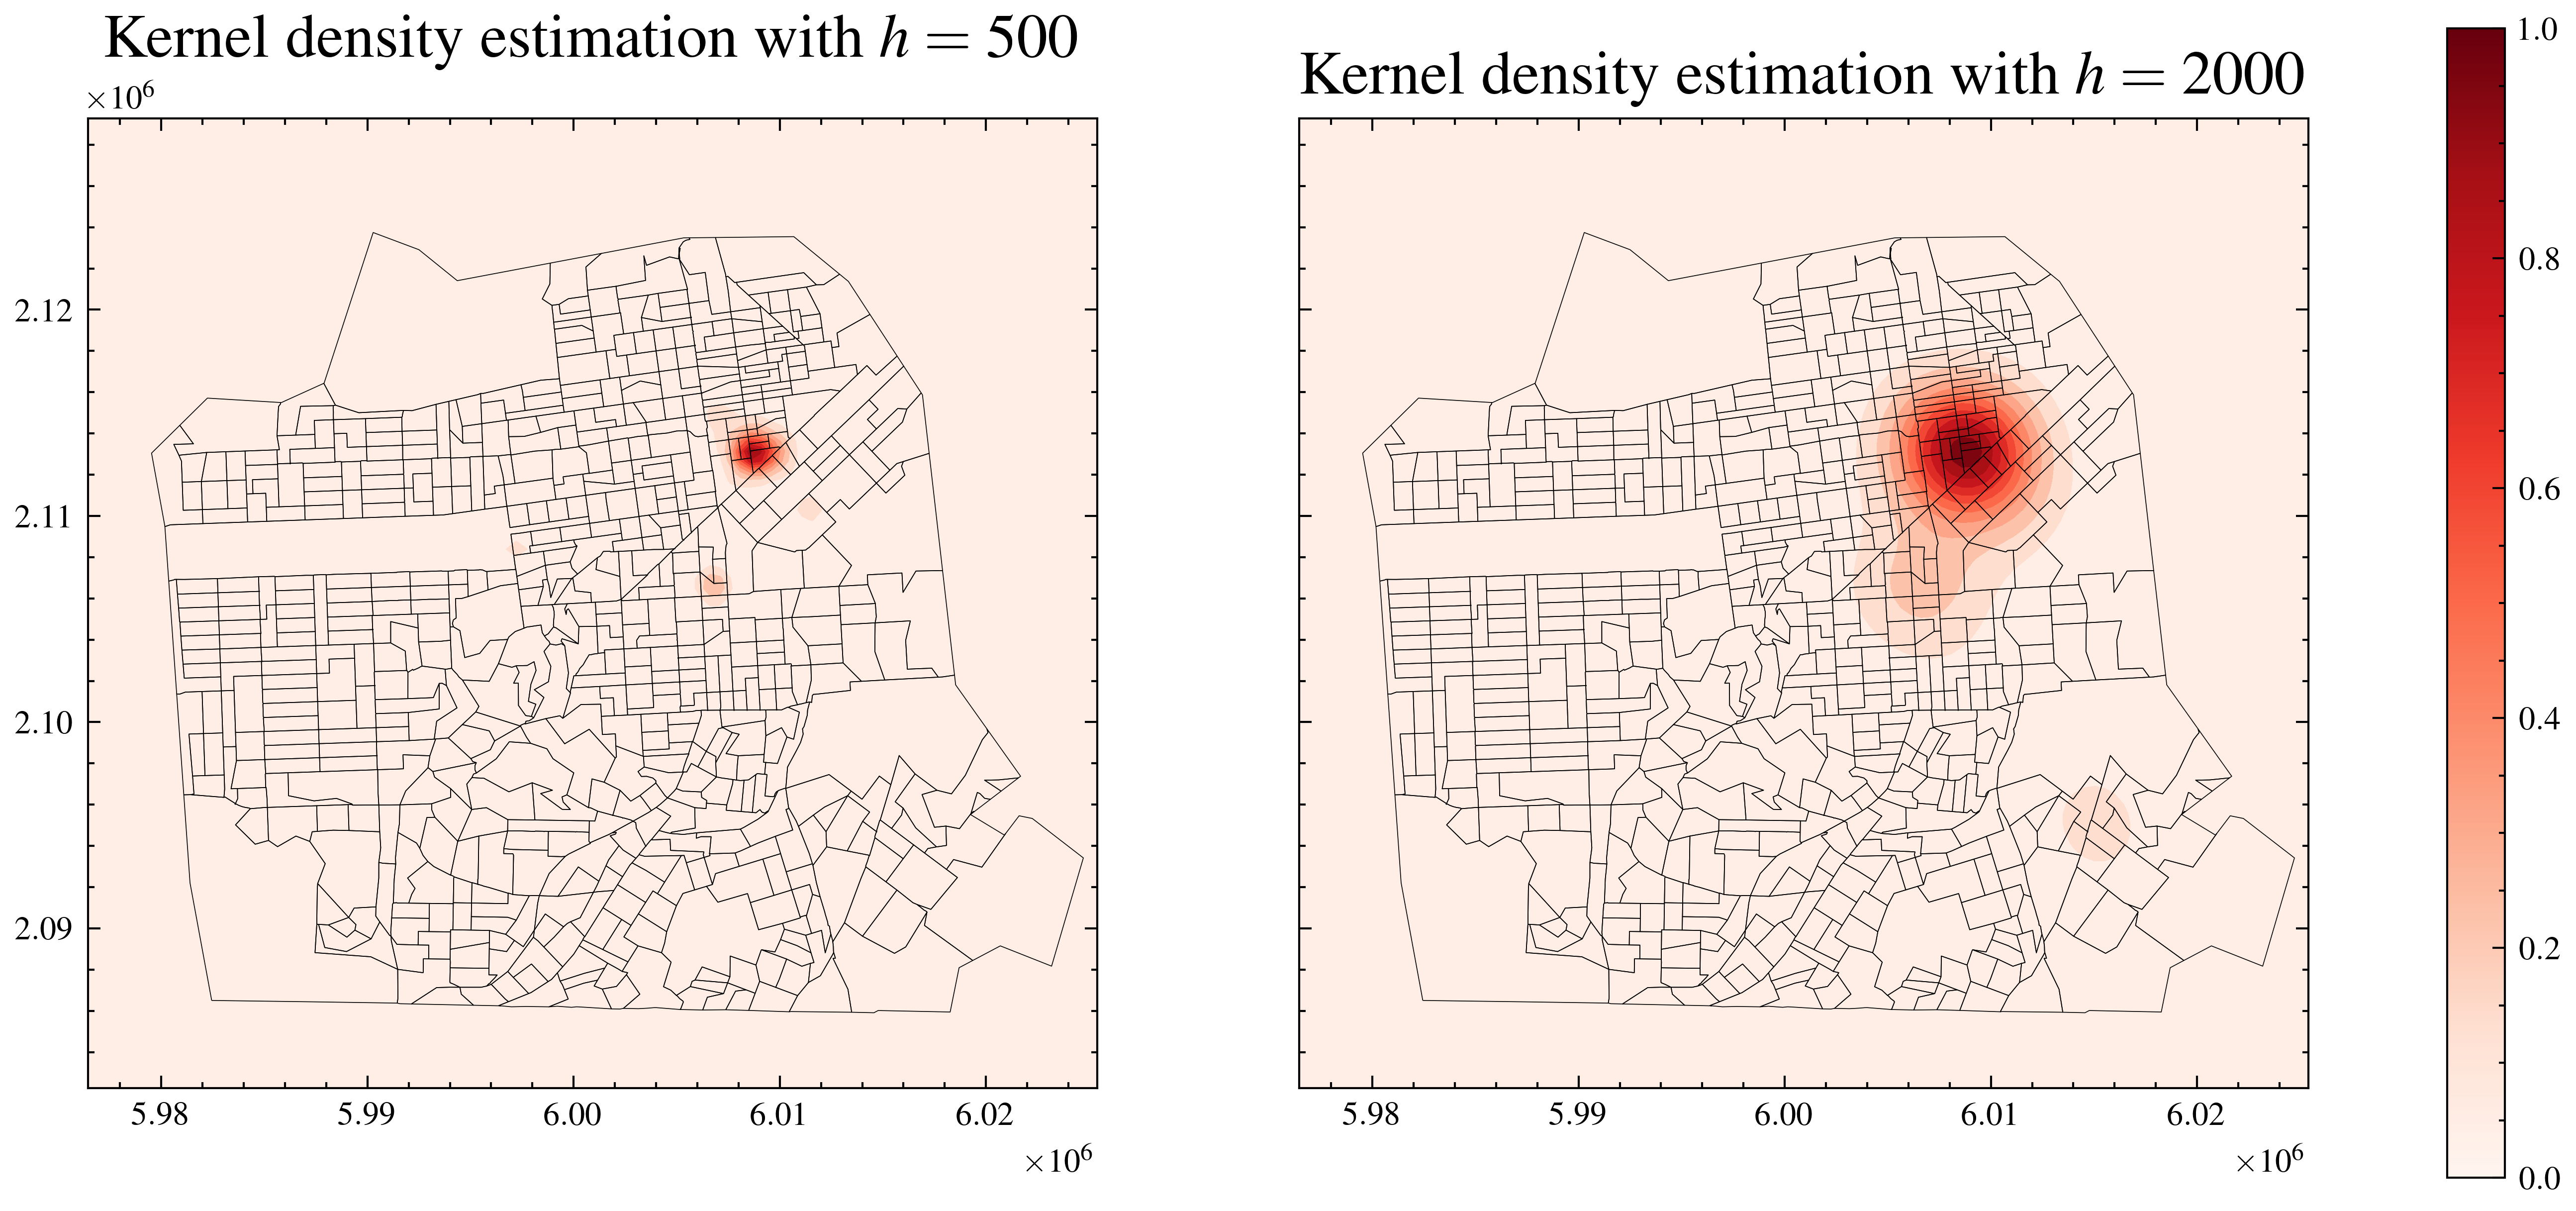

In [181]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
cs = plot_density(ax=axes[0], data=drugs, bandwidth=500, cmap='Reds', fill=True)
blocks.boundary.plot(ax=axes[0], lw=0.2)
axes[0].set_title('Kernel density estimation with $h=500$', fontsize=15)

cs2 = plot_density(ax=axes[1], data=drugs, bandwidth=2000, cmap='Reds', fill=True)
blocks.boundary.plot(ax=axes[1], lw=0.2)
axes[1].set_title('Kernel density estimation with $h=2000$', fontsize=15)
cbar = fig.colorbar(mappable=None, orientation='vertical', cax=None, ax=axes, cmap='Reds')
plt.show()